In [41]:
from pycpd import RigidRegistration, AffineRegistration, DeformableRegistration


In [2]:
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors


def euclidean_distance(point1, point2):
    """
    Euclidean distance between two points.
    :param point1: the first point as a tuple (a_1, a_2, ..., a_n)
    :param point2: the second point as a tuple (b_1, b_2, ..., b_n)
    :return: the Euclidean distance
    """
    a = np.array(point1)
    b = np.array(point2)

    return np.linalg.norm(a - b, ord=2)


def point_based_matching(point_pairs):
    """
    This function is based on the paper "Robot Pose Estimation in Unknown Environments by Matching 2D Range Scans"
    by F. Lu and E. Milios.

    :param point_pairs: the matched point pairs [((x1, y1), (x1', y1')), ..., ((xi, yi), (xi', yi')), ...]
    :return: the rotation angle and the 2D translation (x, y) to be applied for matching the given pairs of points
    """

    x_mean = 0
    y_mean = 0
    xp_mean = 0
    yp_mean = 0
    n = len(point_pairs)

    if n == 0:
        return None, None, None

    for pair in point_pairs:

        (x, y), (xp, yp) = pair

        x_mean += x
        y_mean += y
        xp_mean += xp
        yp_mean += yp

    x_mean /= n
    y_mean /= n
    xp_mean /= n
    yp_mean /= n

    s_x_xp = 0
    s_y_yp = 0
    s_x_yp = 0
    s_y_xp = 0
    for pair in point_pairs:

        (x, y), (xp, yp) = pair

        s_x_xp += (x - x_mean)*(xp - xp_mean)
        s_y_yp += (y - y_mean)*(yp - yp_mean)
        s_x_yp += (x - x_mean)*(yp - yp_mean)
        s_y_xp += (y - y_mean)*(xp - xp_mean)

    rot_angle = math.atan2(s_x_yp - s_y_xp, s_x_xp + s_y_yp)
    translation_x = xp_mean - (x_mean*math.cos(rot_angle) - y_mean*math.sin(rot_angle))
    translation_y = yp_mean - (x_mean*math.sin(rot_angle) + y_mean*math.cos(rot_angle))

    return rot_angle, translation_x, translation_y


def icp(reference_points, points, max_iterations=100, distance_threshold=0.3, convergence_translation_threshold=1e-3,
        convergence_rotation_threshold=1e-4, point_pairs_threshold=10, verbose=False):
    """
    An implementation of the Iterative Closest Point algorithm that matches a set of M 2D points to another set
    of N 2D (reference) points.

    :param reference_points: the reference point set as a numpy array (N x 2)
    :param points: the point that should be aligned to the reference_points set as a numpy array (M x 2)
    :param max_iterations: the maximum number of iteration to be executed
    :param distance_threshold: the distance threshold between two points in order to be considered as a pair
    :param convergence_translation_threshold: the threshold for the translation parameters (x and y) for the
                                              transformation to be considered converged
    :param convergence_rotation_threshold: the threshold for the rotation angle (in rad) for the transformation
                                               to be considered converged
    :param point_pairs_threshold: the minimum number of point pairs the should exist
    :param verbose: whether to print informative messages about the process (default: False)
    :return: the transformation history as a list of numpy arrays containing the rotation (R) and translation (T)
             transformation in each iteration in the format [R | T] and the aligned points as a numpy array M x 2
    """

    transformation_history = []

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(reference_points)
    is_converged = False
    current_distance = 100000
    for iter_num in range(max_iterations):
        if verbose:
            print('------ iteration', iter_num, '------')

        closest_point_pairs = []  # list of point correspondences for closest point rule

        distances, indices = nbrs.kneighbors(points)
        for nn_index in range(len(distances)):
            if distances[nn_index][0] < distance_threshold:
                closest_point_pairs.append((points[nn_index], reference_points[indices[nn_index][0]]))

        # if only few point pairs, stop process
        if verbose:
            print('number of pairs found:', len(closest_point_pairs))
        if len(closest_point_pairs) < point_pairs_threshold:
            if verbose:
                print('No better solution can be found (very few point pairs)!')
            break

        # compute translation and rotation using point correspondences
        closest_rot_angle, closest_translation_x, closest_translation_y = point_based_matching(closest_point_pairs)
        if closest_rot_angle is not None:
            if verbose:
                print('Rotation:', math.degrees(closest_rot_angle), 'degrees')
                print('Translation:', closest_translation_x, closest_translation_y)
        if closest_rot_angle is None or closest_translation_x is None or closest_translation_y is None:
            if verbose:
                print('No better solution can be found!')
            break

        # transform 'points' (using the calculated rotation and translation)
        c, s = math.cos(closest_rot_angle), math.sin(closest_rot_angle)
        rot = np.array([[c, -s],
                        [s, c]])
        aligned_points = np.dot(points, rot.T)
        aligned_points[:, 0] += closest_translation_x
        aligned_points[:, 1] += closest_translation_y

        # update 'points' for the next iteration
        points = aligned_points

        # update transformation history
        transformation_history.append(np.hstack((rot, np.array([[closest_translation_x], [closest_translation_y]]))))

        # check convergence
        if (abs(closest_rot_angle) < convergence_rotation_threshold) \
                and (abs(closest_translation_x) < convergence_translation_threshold) \
                and (abs(closest_translation_y) < convergence_translation_threshold):
            if verbose:
                print('Converged!')
            is_converged = True
            break

    return transformation_history, points, is_converged

In [3]:
import json
with open("libya-simple.json") as f:
        data = json.loads(f.read())
    
def parse_roads(elements, allowed_nodes = None):
    adjacency_list = {}
    node_to_coords = {}

    for road in elements:
        nodes = road['nodes']
        geometry = road['geometry']
        
        # Fill node_to_coords dictionary
        for node, coord in zip(nodes, geometry):
            if allowed_nodes is None or  node in allowed_nodes :
                node_to_coords[node] = (coord['lat'], coord['lon'])
        
        # Fill adjacency list
        for i in range(len(nodes) - 1):
            if allowed_nodes is None or (nodes[i] in allowed_nodes and nodes[i+1] in allowed_nodes ) :
                if nodes[i] not in adjacency_list:
                    adjacency_list[nodes[i]] = []
                if nodes[i + 1] not in adjacency_list:
                    adjacency_list[nodes[i + 1]] = []
                adjacency_list[nodes[i]].append(nodes[i + 1])
                adjacency_list[nodes[i + 1]].append(nodes[i])
    
    return adjacency_list, node_to_coords

adjacency_list, node_to_coords = parse_roads(data['elements'])

# download_tracks(adjacency_list, node_to_coords)

In [4]:
import matplotlib.pyplot as plt

In [5]:
nodes = list(node_to_coords.keys())

In [6]:
# plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
# plt.show()

In [7]:
def fst(el):
    a,b  = el
    return a
def snd(el):
    a,b  = el
    return b

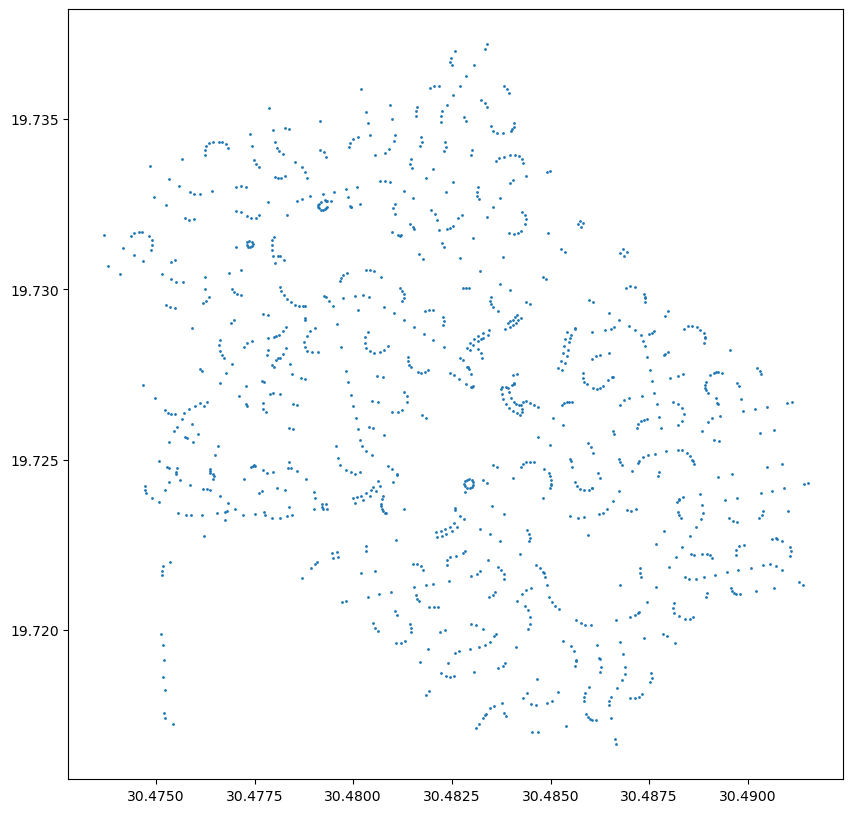

In [8]:


MIN_LAT = 30.47160887744136
MAX_LAT = 30.49365033898752
MIN_LON = 19.712176322937015
MAX_LON = 19.742817878723148 

def isValid(x):
    lat, lon = x
    if lat > MAX_LAT or lat < MIN_LAT or  lon > MAX_LON or lon < MIN_LON:
        return False
    return True
  
locations = list(filter(isValid, node_to_coords.values()))

lat = list(map(fst, locations))
lon = list(map(snd, locations))
plt.figure(figsize=(10, 10))

plt.scatter(lat, lon,  s=1)

plt.show()

In [8]:
# locations

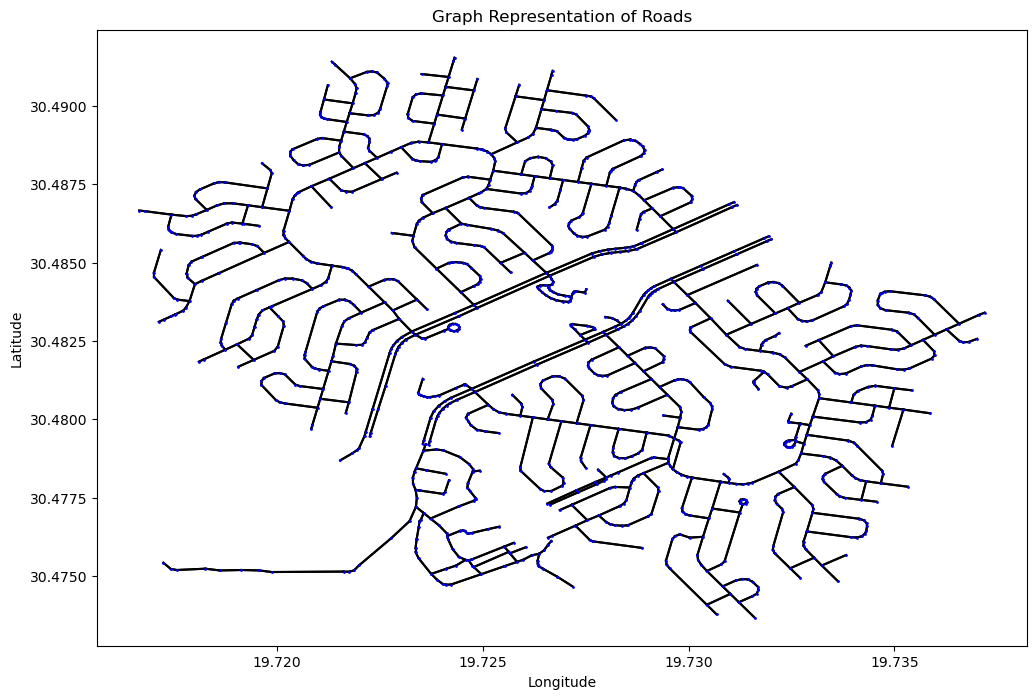

In [9]:
def display_graph(adjacency_list, node_to_coords):
    plt.figure(figsize=(12, 8))
    
    # Plot nodes

    
    # Plot edges
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            lat1, lon1 = node_to_coords[node]
            lat2, lon2 = node_to_coords[neighbor]
            if isValid((lat1, lon1 )) and isValid((lat2, lon2)) :
                plt.plot([lon1, lon2], [lat1, lat2], 'k-')  # 'k-' means black color and solid line
    for node, (lat, lon) in node_to_coords.items():
        if isValid((lat, lon )):
            plt.plot(lon, lat, 'bo',  markersize=1)  # 'bo' means blue color and circle marker 
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Graph Representation of Roads')
#     plt.grid(True)
    plt.show()

# Example usage
# Assuming adjacency_list and node_to_coords are already defined
display_graph(adjacency_list, node_to_coords)

In [10]:
def display_graph_x(adjacency_list, node_to_coords):
    plt.figure(figsize=(12, 8))
    
    # Plot nodes

    
    # Plot edges
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            lat1, lon1 = node_to_coords[node]
            lat2, lon2 = node_to_coords[neighbor]
            if isValid((lat1, lon1 )) and isValid((lat2, lon2)) :
                plt.plot([lon1, lon2], [lat1, lat2], 'k-')  # 'k-' means black color and solid line
    for node, (lat, lon) in node_to_coords.items():
        if isValid((lat, lon )):
            plt.plot(lon, lat, 'rx',  markersize=6)  # 'bo' means blue color and circle marker 
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Graph Representation of Roads')
#     plt.grid(True)
    plt.show()

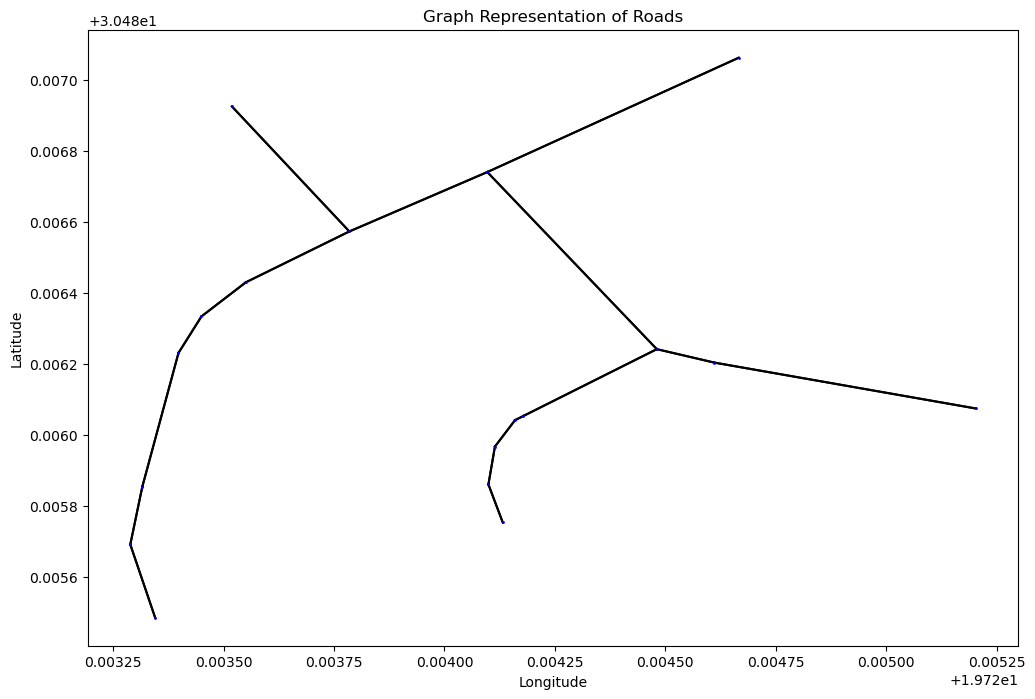

In [11]:
with open("higgins.json") as f:
        higgins_data = json.loads(f.read()) 
allowed_nodes = [1364511242,
 1364510515,
 5560583307,
 1364508915,
 1364510717,
 1364511719,
 1364510515,
 1364508506,
 9818171099,
 1364508915,
 5560583299,
 1364508915,
 1364511409,
 9818171099,
 1364510096,
 1364511409,
 1364509696,
 1364510096,
 5560583297,
 1364511719,
 5560583311,
 5560583307,
 1364511173,
 5560583311,
 1364564359,
 1364564359,
 1364510865,
 5560583310]
adjacency_list_h, node_to_coords_h = parse_roads(higgins_data['elements'], allowed_nodes)

display_graph(adjacency_list_h, node_to_coords_h )

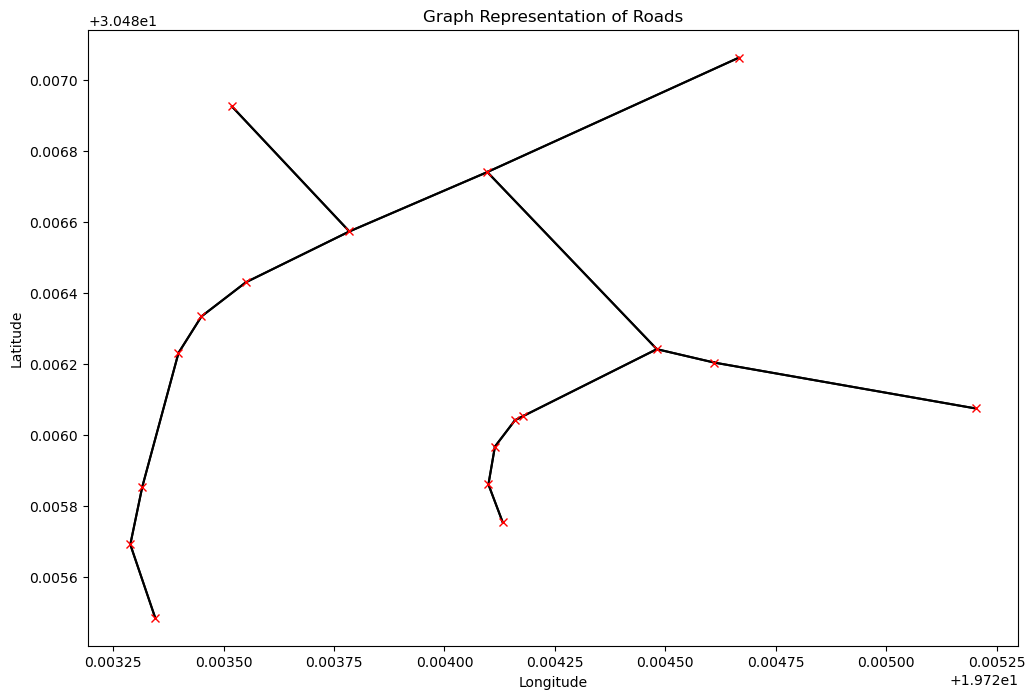

In [12]:
display_graph_x(adjacency_list_h, node_to_coords_h )

In [13]:
 import itertools


coords = [node_to_coords_h[x] for x in itertools.chain.from_iterable(    adjacency_list_h.values())]    
lavel = [x for x in itertools.chain.from_iterable(    adjacency_list_h.values())]    

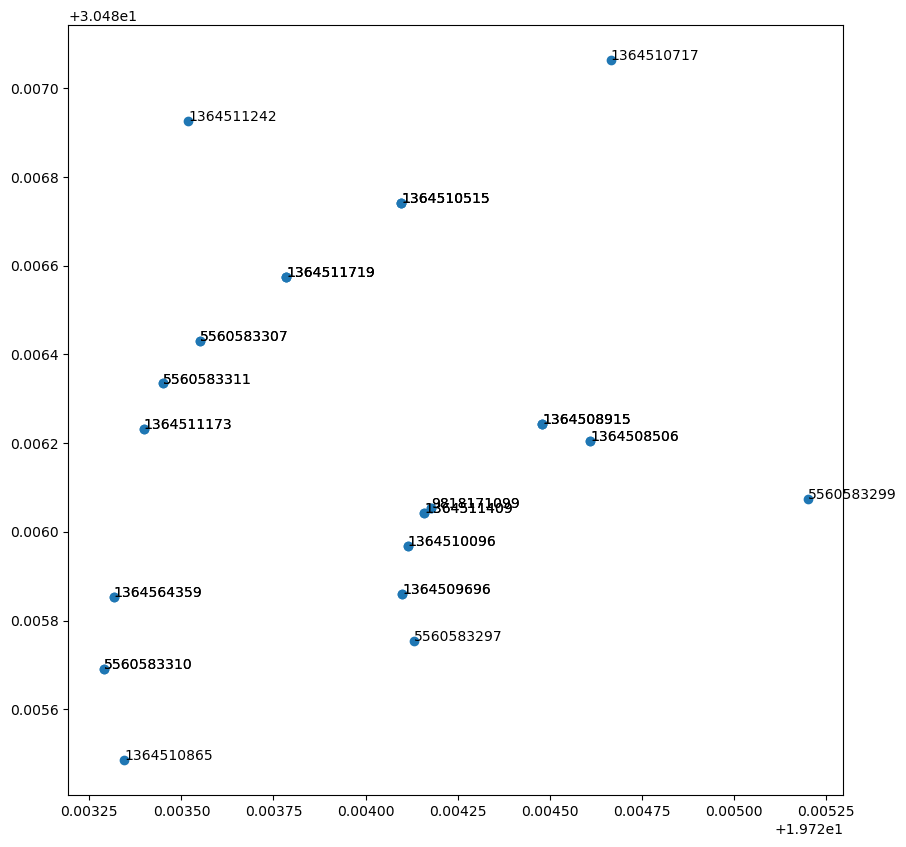

In [14]:
lat = list(map(fst, coords))
lon = list(map(snd, coords))
fig, ax = plt.subplots(figsize=(10, 10))

# fig, ax = plt.scatter(x, y)

plt.scatter(lon, lat  )
for i in range( len(lavel)):
    plt.text(lon[i], lat[i], str(lavel[i]))

plt.show()

In [15]:
# lavel

In [16]:
adjacency_list_h

{1364511719: [1364511242, 1364510515, 5560583307],
 1364511242: [1364511719],
 1364510515: [1364508915, 1364510717, 1364511719],
 1364508915: [1364510515, 1364508506, 9818171099],
 1364508506: [1364508915, 5560583299],
 5560583299: [1364508506],
 9818171099: [1364508915, 1364511409],
 1364511409: [9818171099, 1364510096],
 1364510096: [1364511409, 1364509696],
 1364509696: [1364510096, 5560583297],
 5560583297: [1364509696],
 1364510717: [1364510515],
 5560583307: [1364511719, 5560583311],
 5560583311: [5560583307, 1364511173],
 1364511173: [5560583311, 1364564359],
 1364564359: [1364511173, 5560583310],
 5560583310: [1364564359, 1364510865],
 1364510865: [5560583310]}

In [17]:
node_to_coords_h

{1364511719: (30.486574, 19.7237847),
 1364511242: (30.4869263, 19.7235189),
 1364510515: (30.4867414, 19.724097),
 1364508915: (30.4862422, 19.7244807),
 1364508506: (30.4862043, 19.724611),
 5560583299: (30.486075, 19.7252027),
 1364510717: (30.4870637, 19.7246661),
 9818171099: (30.486054, 19.7241789),
 1364511409: (30.486042, 19.7241597),
 1364510096: (30.4859675, 19.7241142),
 1364509696: (30.4858609, 19.7240995),
 5560583297: (30.4857539, 19.7241319),
 5560583307: (30.4864306, 19.7235503),
 5560583311: (30.4863345, 19.7234499),
 1364511173: (30.4862316, 19.7233979),
 1364564359: (30.485854, 19.7233159),
 5560583310: (30.4856916, 19.7232888),
 1364510865: (30.4854852, 19.7233451)}

In [18]:
import math

def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

def interpolate_nodes(coord1, coord2, d):
    dist = euclidean_distance(coord1, coord2)
    num_new_nodes = math.ceil(dist / d) - 1
    new_nodes = []
    for i in range(1, num_new_nodes + 1):
        new_lat = coord1[0] + (coord2[0] - coord1[0]) * i / (num_new_nodes + 1)
        new_lon = coord1[1] + (coord2[1] - coord1[1]) * i / (num_new_nodes + 1)
        new_nodes.append((new_lat, new_lon))
    return new_nodes

def interpolate_graph(adjacency_list, node_to_lat_lon, d):
    new_adjacency_list = {}
    new_node_to_lat_lon = node_to_lat_lon.copy()
    next_node_id = max(new_node_to_lat_lon.keys()) + 1
    
    for node, neighbors in adjacency_list.items():
        new_adjacency_list[node] = []
        for neighbor in neighbors:
            coord1 = node_to_lat_lon[node]
            coord2 = node_to_lat_lon[neighbor]
            dist = euclidean_distance(coord1, coord2)
            if dist > d:
                new_nodes = interpolate_nodes(coord1, coord2, d)
                last_node = node
                for new_node_coord in new_nodes:
                    new_node_to_lat_lon[next_node_id] = new_node_coord
                    new_adjacency_list[last_node].append(next_node_id)
                    new_adjacency_list[next_node_id] = [last_node]
                    last_node = next_node_id
                    next_node_id += 1
                new_adjacency_list[last_node].append(neighbor)
                if neighbor in new_adjacency_list:
                    new_adjacency_list[neighbor].append(last_node)
                else:
                    new_adjacency_list[neighbor] = [last_node]
            else:
                new_adjacency_list[node].append(neighbor)
                if neighbor in new_adjacency_list:
                    new_adjacency_list[neighbor].append(node)
                else:
                    new_adjacency_list[neighbor] = [node]
                    
    return new_adjacency_list, new_node_to_lat_lon

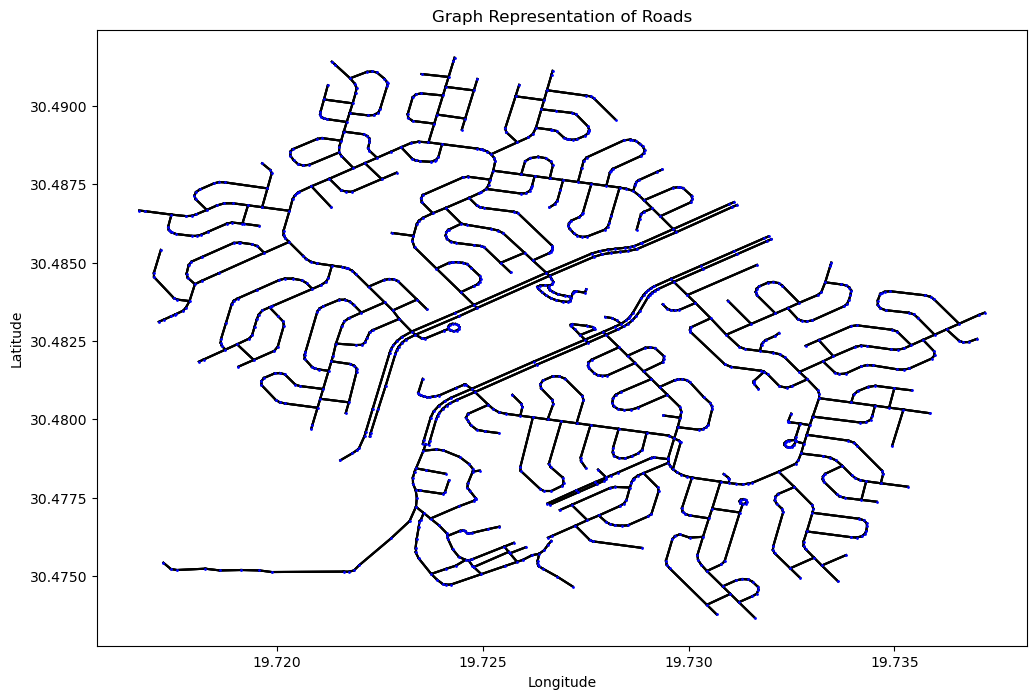

In [19]:
d = 0.0001  # Example distance threshold
d = 0.1  # Example distance threshold

new_adjacency_list, new_node_to_lat_lon = interpolate_graph(adjacency_list, node_to_coords, d)
display_graph(new_adjacency_list, new_node_to_lat_lon )

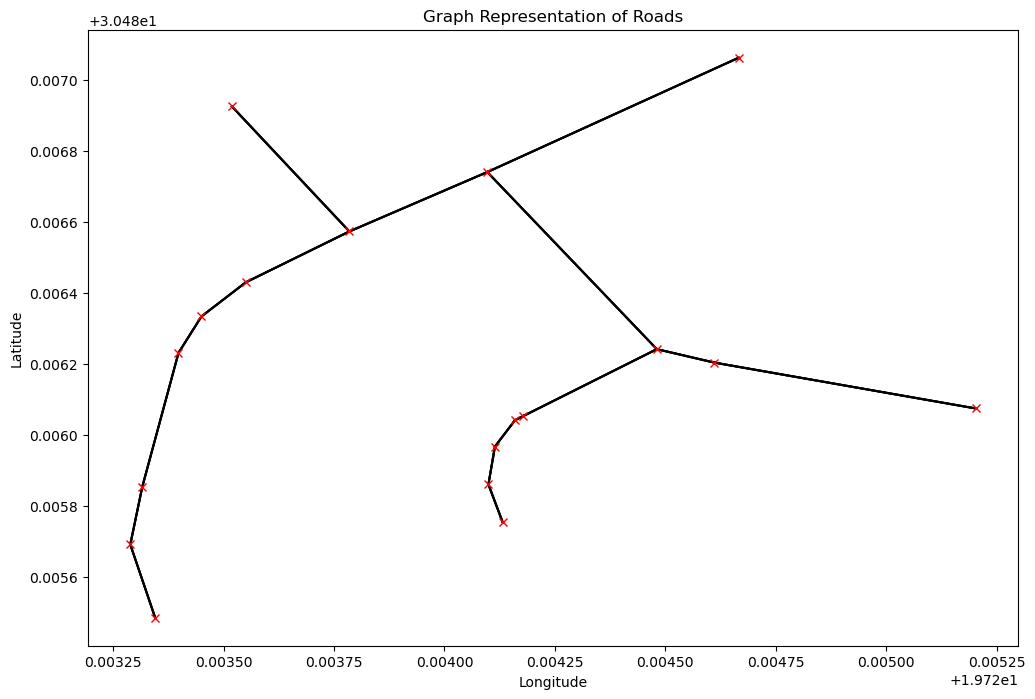

In [20]:
# d = 0.0001  # Example distance threshold

new_adjacency_list_h, new_node_to_lat_lon_h = interpolate_graph(adjacency_list_h, node_to_coords_h ,d)
display_graph_x(new_adjacency_list_h, new_node_to_lat_lon_h  )

In [21]:
len(new_node_to_lat_lon_h)

18

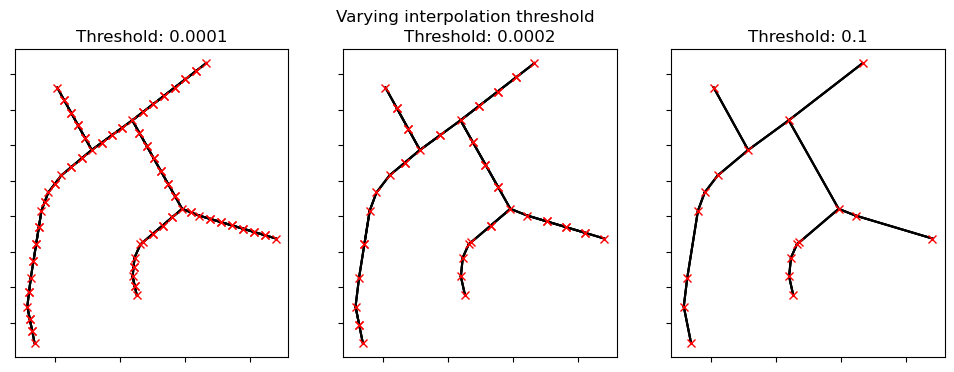

In [22]:
# display_graph_x(*interpolate_graph(adjacency_list_h, node_to_coords_h ,0.0001))


def display_graph_variants(adjacency_list_h, node_to_coords_h):
    variants = [0.0001, 0.0002, 0.1]
    fig, axs = plt.subplots(1, len(variants), figsize=(12, 4))
    fig.suptitle('Varying interpolation threshold')

#     plt.figure(figsize=(12, 8))
    for i in range(len(variants)):
        adjacency_list, node_to_coords = interpolate_graph(adjacency_list_h, node_to_coords_h ,variants[i])
        for node, neighbors in adjacency_list.items():
            for neighbor in neighbors:
                lat1, lon1 = node_to_coords[node]
                lat2, lon2 = node_to_coords[neighbor]
                if isValid((lat1, lon1 )) and isValid((lat2, lon2)) :
                    axs[i].plot([lon1, lon2], [lat1, lat2], 'k-')  # 'k-' means black color and solid line
        for node, (lat, lon) in node_to_coords.items():
            if isValid((lat, lon )):
                axs[i].plot(lon, lat, 'rx',  markersize=6)  # 'bo' means blue color and circle marker 
        axs[i].set_title(f'Threshold: {variants[i]}')

        # Remove x and y labels
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
#         fig.xlabel('Longitude')
#         fig.ylabel('Latitude')
#         plt.title('Graph Representation of Roads')
#     plt.grid(True)
display_graph_variants(adjacency_list_h, node_to_coords_h)

In [23]:
# mean = map_locs.mean(), 
# std = map_locs.std(),

In [42]:
# map_locs.mean(axis=0)



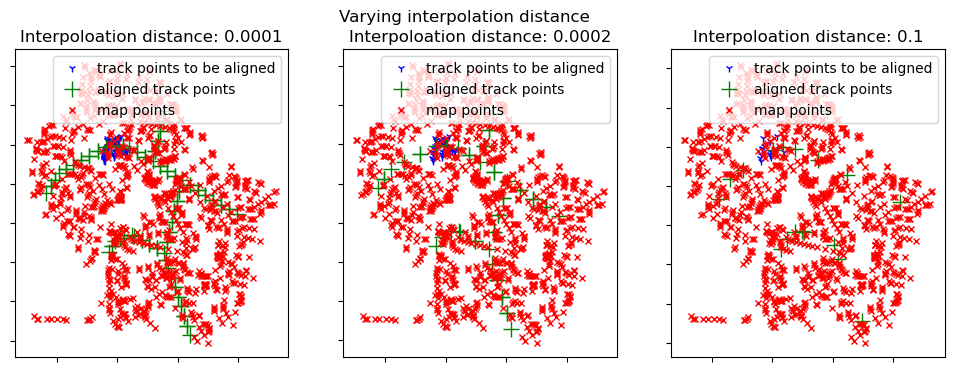

In [47]:
def icp(reference_points, points, max_iterations=100, distance_threshold=0.3, convergence_translation_threshold=1e-3,
        convergence_rotation_threshold=1e-4, point_pairs_threshold=10, verbose=False):
    reg = RigidRegistration(X=reference_points, Y=points)
    # run the registration & collect the results
    TY, rest = reg.register()
    return rest, TY , True


def interpolation_plot(adjacency_list_h, node_to_coords_h):
    variants = [0.0001, 0.0002, 0.1]
    fig, axs = plt.subplots(1, len(variants), figsize=(12, 4))
    fig.suptitle('Varying interpolation distance')

#     plt.figure(figsize=(12, 8))
    for i in range(len(variants)):
        adjacency_list, node_to_coords = interpolate_graph(adjacency_list_h, node_to_coords_h ,variants[i])
        map_locs = np.array(list(new_node_to_lat_lon.values()))
        track_locs = np.array(list(node_to_coords.values()))
        t = track_locs.mean(axis=0)
# t = map_locs.mean(axis=0)

        map_locs =  map_locs - t
        track_locs = track_locs - t
        track_locs = track_locs - [0.0002, 0.0003]
        transformation_history, aligned_points , converged= icp(map_locs, track_locs  , verbose=False, max_iterations=7, distance_threshold = 0.0004, convergence_translation_threshold=0.00000001,
        convergence_rotation_threshold=1e-9, point_pairs_threshold=18)
    
        # MIN_LAT = 30.47160887744136
        # MAX_LAT = 30.49365033898752
        # MIN_LON = 19.712176322937015
        # MAX_LON = 19.742817878723148 
#         ax.set(xlim=(MIN_LON, MAX_LON), ylim=(MIN_LAT, MAX_LAT))
        # axs[i].set(xlim=(-0.0025, 0.0025), ylim=(-0.0025, 0.0025))

        axs[i].plot(track_locs[:, 1], track_locs[:, 0], 'b1', label='track points to be aligned',   markersize=6)
        axs[i].plot(aligned_points[:, 1], aligned_points[:, 0], 'g+', label='aligned track points',  markersize=12)
        axs[i].plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='map points',  markersize=5)

        axs[i].legend()
        axs[i].set_title(f'Interpoloation distance: {variants[i]}')

        # Remove x and y labels
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
#         fig.xlabel('Longitude')
#         fig.ylabel('Latitude')
#         plt.title('Graph Representation of Roads')
#     plt.grid(True)
interpolation_plot(adjacency_list_h, node_to_coords_h)

In [26]:
# map_locs - [30.48246328, 19.72672631]

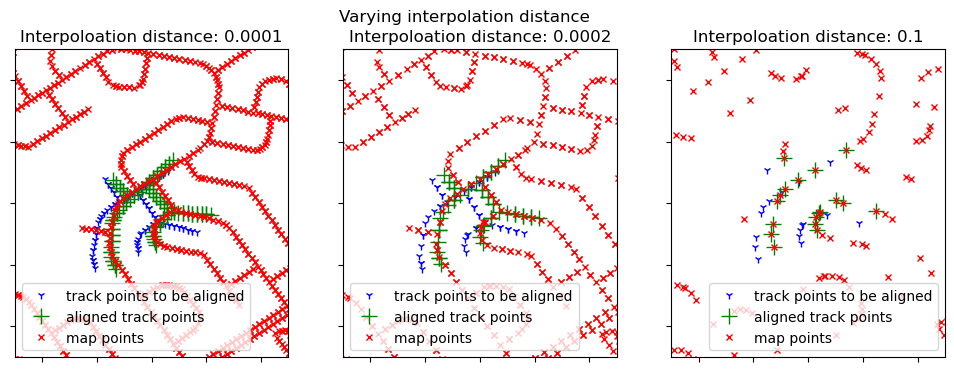

In [27]:
def interpolation_plot_2(adjacency_list_h, node_to_coords_h, adjacency_list_mo, node_to_coords_mo):
    variants = [0.0001, 0.0002, 0.1]
    fig, axs = plt.subplots(1, len(variants), figsize=(12, 4))
    fig.suptitle('Varying interpolation distance')

#     plt.figure(figsize=(12, 8))
    for i in range(len(variants)):
        adjacency_list, node_to_coords = interpolate_graph(adjacency_list_h, node_to_coords_h ,variants[i])
        adjacency_list_m, node_to_coords_m = interpolate_graph(adjacency_list_mo, node_to_coords_mo ,variants[i])
        map_locs = np.array(list(node_to_coords_m.values()))
        track_locs = np.array(list(node_to_coords.values()))
        t = track_locs.mean(axis=0)
# t = map_locs.mean(axis=0)

        map_locs =  map_locs - t
        track_locs = track_locs - t
        track_locs = track_locs - [0.0002, 0.0003]
        transformation_history, aligned_points , converged= icp(map_locs, track_locs  , verbose=False, max_iterations=7, distance_threshold = 0.0004, convergence_translation_threshold=0.00000001,
        convergence_rotation_threshold=1e-9, point_pairs_threshold=18)
    
        # MIN_LAT = 30.47160887744136
        # MAX_LAT = 30.49365033898752
        # MIN_LON = 19.712176322937015
        # MAX_LON = 19.742817878723148 
#         ax.set(xlim=(MIN_LON, MAX_LON), ylim=(MIN_LAT, MAX_LAT))
        axs[i].set(xlim=(-0.0025, 0.0025), ylim=(-0.0025, 0.0025))

        axs[i].plot(track_locs[:, 1], track_locs[:, 0], 'b1', label='track points to be aligned',   markersize=6)
        axs[i].plot(aligned_points[:, 1], aligned_points[:, 0], 'g+', label='aligned track points',  markersize=12)
        axs[i].plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='map points',  markersize=5)

        axs[i].legend()
        axs[i].set_title(f'Interpoloation distance: {variants[i]}')

        # Remove x and y labels
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
#         fig.xlabel('Longitude')
#         fig.ylabel('Latitude')
#         plt.title('Graph Representation of Roads')
#     plt.grid(True)
interpolation_plot_2(adjacency_list_h, node_to_coords_h, adjacency_list, node_to_coords)

In [80]:
map_locs = np.array(list(new_node_to_lat_lon.values()))
track_locs = np.array(list(new_node_to_lat_lon_h.values()))

t = track_locs.mean(axis=0)
# t = map_locs.mean(axis=0)

map_locs =  map_locs - t
track_locs = track_locs - t
track_locs = track_locs - [0.0002, 0.0003]

True

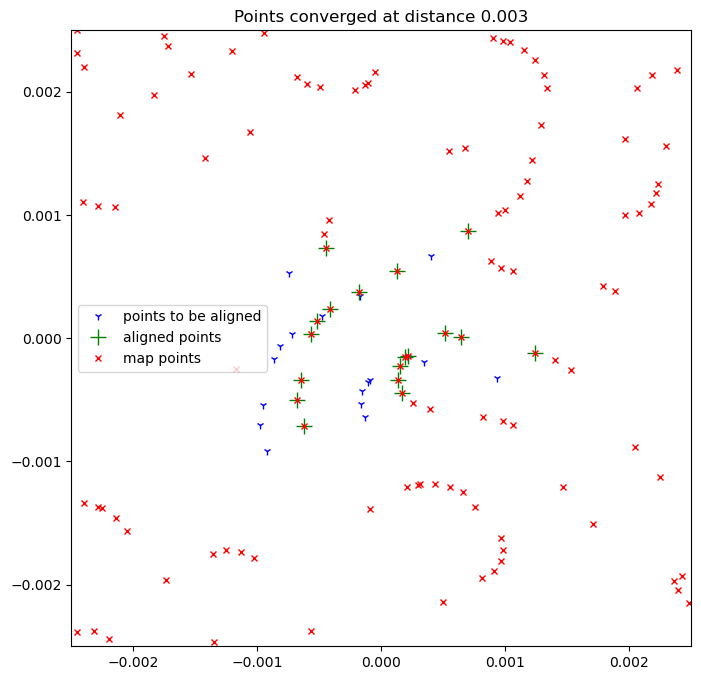

In [82]:
def run_icp(map_locs, track_locs, plot=True, distance_threshold=0.0004):
    transformation_history, aligned_points , converged= icp(map_locs, track_locs  , verbose=False, max_iterations=7, distance_threshold = distance_threshold, convergence_translation_threshold=0.00000001,
        convergence_rotation_threshold=1e-9, point_pairs_threshold=18)
    if plot:
        fig, ax = plt.subplots(figsize=(8,8))
        # MIN_LAT = 30.47160887744136
        # MAX_LAT = 30.49365033898752
        # MIN_LON = 19.712176322937015
        # MAX_LON = 19.742817878723148 
#         ax.set(xlim=(MIN_LON, MAX_LON), ylim=(MIN_LAT, MAX_LAT))
        ax.set(xlim=(-0.0025, 0.0025), ylim=(-0.0025, 0.0025))

        # show results
        ax.set_title("Points converged at distance 0.003")
        ax.plot(track_locs[:, 1], track_locs[:, 0], 'b1', label='track points to be aligned',   markersize=6)
        ax.plot(aligned_points[:, 1], aligned_points[:, 0], 'g+', label='aligned track points',  markersize=12)
        ax.plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='map points',  markersize=5)

        ax.legend()
    return converged
    # ax.show()
run_icp(map_locs, track_locs, plot=True)

In [54]:
transformation_history

NameError: name 'transformation_history' is not defined

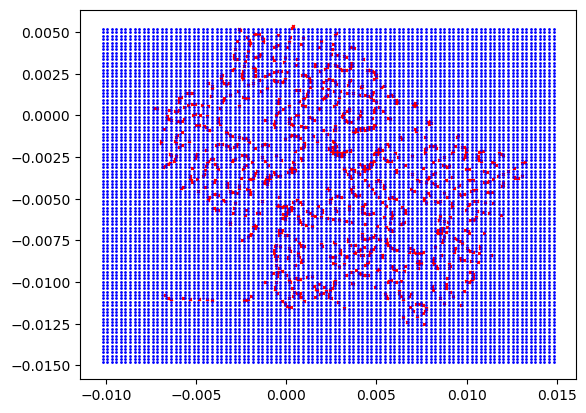

In [55]:
plt.plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='reference points',  markersize=2)

for i in np.linspace(-0.005, 0.015, 100):
    for j in np.linspace(-0.015, 0.01, 100):
        t_track = track_locs - [i, j]
        plt.plot(t_track[:1, 1], t_track[:1, 0], 'bo', label='points to be aligned',   markersize=1)


In [56]:
# plt.plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='reference points',  markersize=2)


In [57]:
# len(candidates)

In [58]:
# np.linspace(-0.015, 0.01, 25, False)

34


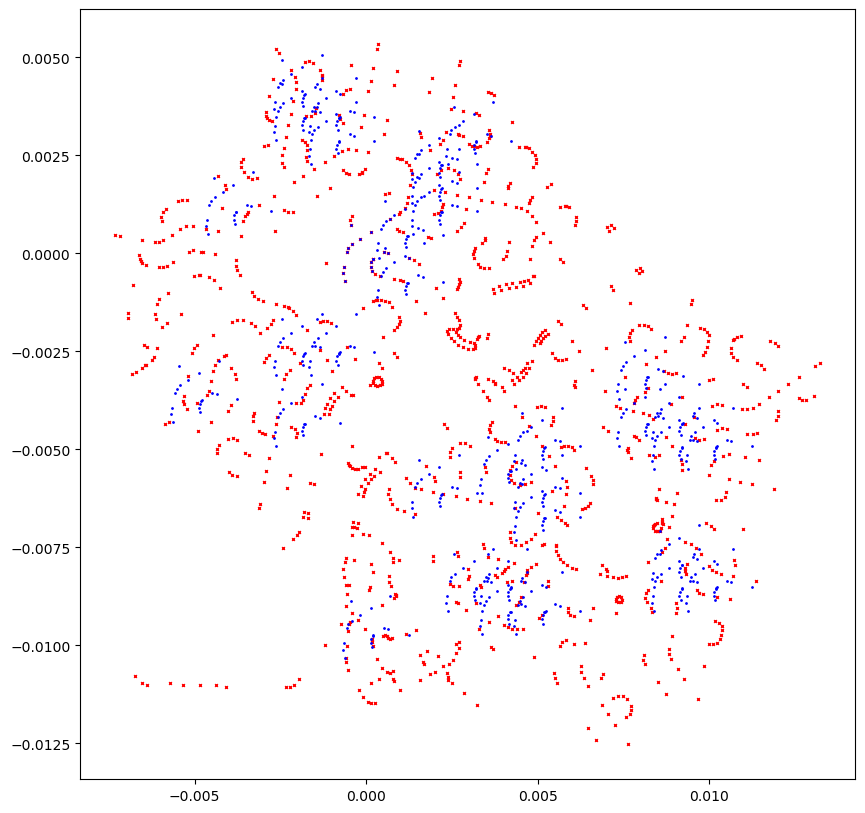

In [59]:
candidates = []
for i in np.linspace(-0.005, 0.01, 25, False):
    for j in np.linspace(-0.015, 0.01, 25, False):
        t_track = track_locs - [i, j]
        candidates.append(t_track)
#         plt.plot(t_track[:1, 1], t_track[:1, 0], 'bo', label='points to be aligned',   markersize=1)

converged  = []

for candidate in candidates:
    converged.append(run_icp(map_locs, candidate, plot=False))
    
plt.figure(figsize=(10, 10))

plt.plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='reference points',  markersize=2)
count = 0
for i, candidate in enumerate(candidates):
    if converged[i]:   
        plt.plot(candidate[:, 1], candidate[:, 0], 'bo', label='points to be aligned',   markersize=1)
        count+=1
print(count)    

234
34
1


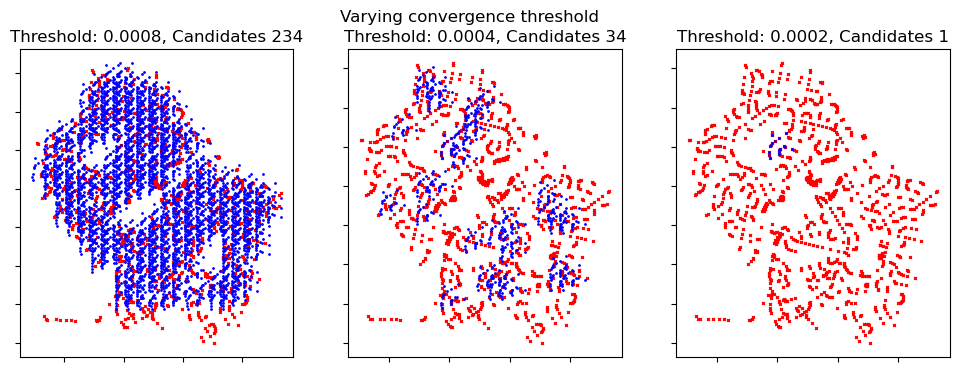

In [70]:
def show_vary_candidated():
    variants = [0.0008, 0.0004, 0.0002]
    fig, axs = plt.subplots(1, len(variants), figsize=(12, 4))
    fig.suptitle('Varying convergence threshold')

    for v in range(len(variants)):
        candidates = []
        for i in np.linspace(-0.005, 0.01, 25, False):
            for j in np.linspace(-0.015, 0.01, 25, False):
                t_track = track_locs - [i, j]
                candidates.append(t_track)

        converged  = []

        for candidate in candidates:
            converged.append(run_icp(map_locs, candidate, plot=False,  distance_threshold=variants[v]))


        axs[v].plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='reference points',  markersize=2)
        count = 0
        for i, candidate in enumerate(candidates):
            if converged[i]:   
                axs[v].plot(candidate[:, 1], candidate[:, 0], 'bo', label='points to be aligned',   markersize=1)
                count+=1
                
        axs[v].set_title(f'Threshold: {variants[v]}, Candidates {count}')

        # Remove x and y labels
        axs[v].set_xlabel('')
        axs[v].set_ylabel('')
        axs[v].set_yticklabels([])
        axs[v].set_xticklabels([])
        print(count)    
        
show_vary_candidated()


1


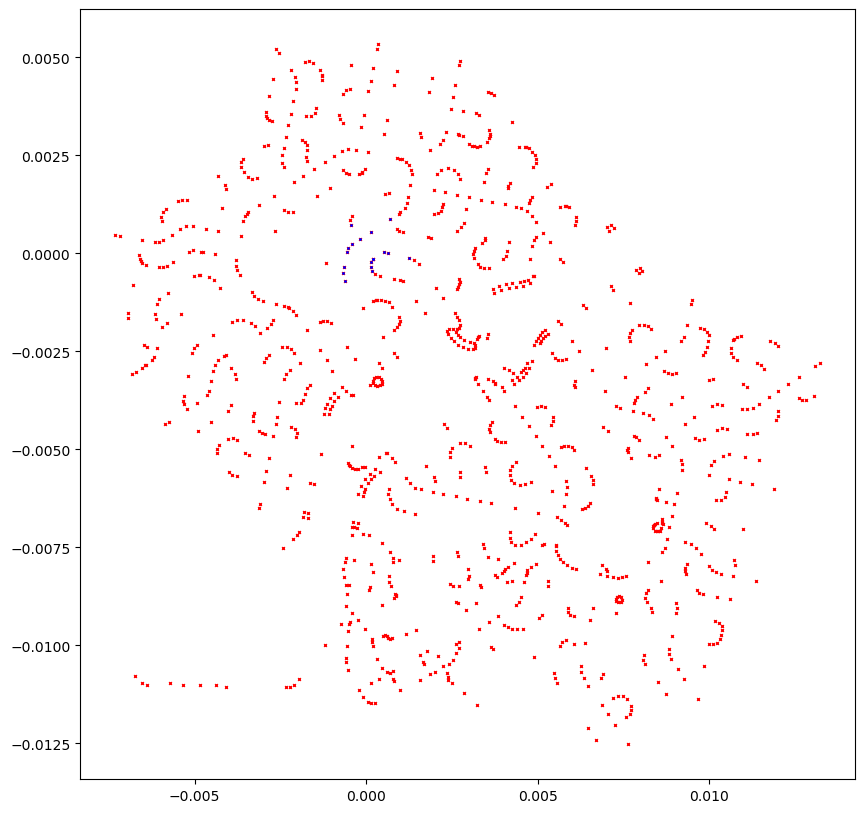

In [ ]:
# plt.plot(map_locs[:, 1], map_locs[:, 0], 'rx', label='reference points',  markersize=2)
# plt.plot(t_track[:, 1], t_track[:, 0], 'bo', label='points to be aligned',   markersize=1)
